 ### please re-start kernel if these packages are installed for the first time

In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

### This template is for
- objFuncs: v1.0.3  
- pyBO: v1.0.1

In [3]:
import objFuncs
from objFuncs import maximize_FC, construct_machineIO
from objFuncs.util import get_MEBT_objective_goal_from_BPMoverview
from objFuncs.preset import get_preset, get_tolerance
from pyBO import pyBO

objFuncs version: 1.0.3. updated on 2024-03-11
pyBO version: 1.0.1. updated on 2024-03-15


In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget,fetch_data
import pandas as pd

# user inputs
### check and adjust decision (control knobs) and objectives later

In [5]:
is_close_to_opt = False  # True for local optimization. 
FC814 = 30              # uA
timespan_for_average = 2.0    # sec  
additional_wait_after_powersupply_ramp  = 0.25 # sec

# BPM_snapshot will just display objective goal template from snapshot
BPM_snapshot_fname = '20230527_1926_124Xe26_3q_216p5MeVu.bpm'  
# BPM_snapshot_fname = None

In [6]:
budget = 60
if not is_close_to_opt:
    budget += int(0.5*budget)
    
print(f"budget: {budget}")

budget: 100


# check machineIO, source and beam  

In [7]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = timespan_for_average
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = additional_wait_after_powersupply_ramp

In [8]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS1 124Xe26 A/Q= 4.769230769230769


In [9]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][pyBO][MEBT]FC1102'
fname

'20240320_0932[124Xe26][pyBO][MEBT]FC1102'

# preprare decision ( control knob)

In [10]:
# preset = get_preset('[MEBT]FC1102',BPM_snapshot_fname=BPM_snapshot_fname)
# for k,v in preset.items():
#     if 'decision' in k:
#         print(f'==== {k} ====')
#         display(v)

In [11]:
decision_CSETs = [
#                  'FE_LEBT:PSC2_D0948:I_CSET', 'FE_LEBT:PSC1_D0948:I_CSET',
                 'FE_LEBT:PSC2_D0964:I_CSET', 'FE_LEBT:PSC1_D0964:I_CSET',
                 'FE_LEBT:PSC2_D0979:I_CSET', 'FE_LEBT:PSC1_D0979:I_CSET',
                 'FE_LEBT:PSC2_D0992:I_CSET', 'FE_LEBT:PSC1_D0992:I_CSET',
                  ]
ave, _ = fetch_data(decision_CSETs,0.01)

decision_tols = []
decision_min = []
decision_max = []
for v, PV in zip(ave,decision_CSETs):
    if 'PSC' in PV:
        decision_min.append(v-AQ)
        decision_max.append(v+AQ)
        decision_tols.append(0.2)
    elif 'PSOL' in PV:
        decision_min.append(0.9*v)
        decision_max.append(1.1*v)
        decision_tols.append(1.0)
    else:
        raise ValueError(f'decision bounds for {PV} cannot be determined')

# decision_tol = get_tolerance(decision_CSETs)
# if decision_tol is None:
#     decision_tol = [0.2]*len(decision_CSETs)

pd.DataFrame(np.array([ave,decision_min,decision_max,decision_tols]).T,
             index=decision_CSETs, 
             columns=['current value','decision min','decision max','tol'])

,current value,decision min,decision max,tol
FE_LEBT:PSC2_D0964:I_CSET,-3.500277e-03,-4.772731,4.765730,0.2
FE_LEBT:PSC1_D0964:I_CSET,-3.390662e-01,-5.108297,4.430165,0.2
FE_LEBT:PSC2_D0979:I_CSET,2.565499e+00,-2.203732,7.334730,0.2
FE_LEBT:PSC1_D0979:I_CSET,-2.527859e-01,-5.022017,4.516445,0.2
FE_LEBT:PSC2_D0992:I_CSET,-2.454513e-08,-4.769231,4.769231,0.2
FE_LEBT:PSC1_D0992:I_CSET,-1.228934e+00,-5.998165,3.540297,0.2


# preprare objective function

In [12]:
# for k,v in preset.items():
#     if 'objective' in k:
#         print(f'==== {k} ====')
#         display(v)

In [13]:
if BPM_snapshot_fname is not None:
    display(get_MEBT_objective_goal_from_BPMoverview(BPM_snapshot_fname))

{'FE_MEBT:BPM_D1056:XPOS_RD': -0.345812289535008,
 'FE_MEBT:BPM_D1056:YPOS_RD': 0.2755291980547795,
 'FE_MEBT:BPM_D1056:PHASE_RD': 80.01379620843083,
 'FE_MEBT:BPM_D1056:MAG_RD': {'more than': None},
 'FE_MEBT:BPM_D1072:XPOS_RD': 0.11800521457630664,
 'FE_MEBT:BPM_D1072:YPOS_RD': 0.4313544346071099,
 'FE_MEBT:BPM_D1072:PHASE_RD': -23.42850231099402,
 'FE_MEBT:BPM_D1072:MAG_RD': {'more than': None},
 'FE_MEBT:BPM_D1094:XPOS_RD': 0.04434067124873937,
 'FE_MEBT:BPM_D1094:YPOS_RD': -0.15548171891011758,
 'FE_MEBT:BPM_D1094:PHASE_RD': -14.992799801690156,
 'FE_MEBT:BPM_D1094:MAG_RD': {'more than': None},
 'FE_MEBT:BCM_D1055:AVGPK_RD': {'more than': None},
 'FE_MEBT:FC_D1102:PKAVG_RD': {'more than': None}}

In [14]:
objective_goal= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : -0.345812289535008,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 0.2755291980547795,
    'FE_MEBT:BPM_D1056:PHASE_RD': 80.01379620843083,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 0.11800521457630664,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 0.4313544346071099,
    'FE_MEBT:BPM_D1072:PHASE_RD': -23.42850231099402,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 0.04434067124873937,
    'FE_MEBT:BPM_D1094:YPOS_RD' : -0.15548171891011758,
    'FE_MEBT:BPM_D1094:PHASE_RD': -14.992799801690156,
    'FE_MEBT:BCM_D1055:AVGPK_RD': {'more than': FC814},
    'FE_MEBT:FC_D1102:PKAVG_RD' : {'more than': 0.8*FC814},
}

In [15]:
objective_norm= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1056:PHASE_RD': 1,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1072:PHASE_RD': 1,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1094:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1094:PHASE_RD': 1,
    'FE_MEBT:BCM_D1055:AVGPK_RD': 0.05*FC814,
    'FE_MEBT:FC_D1102:PKAVG_RD' : 0.05*0.8*FC814,
}

In [16]:
objective_weight= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 0.8,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 0.8,
    'FE_MEBT:BPM_D1056:PHASE_RD': 1,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 0.4,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 0.4,
    'FE_MEBT:BPM_D1072:PHASE_RD': 0.5,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 0.2,
    'FE_MEBT:BPM_D1094:YPOS_RD' : 0.2,
    'FE_MEBT:BPM_D1094:PHASE_RD': 0.25,
    'FE_MEBT:BCM_D1055:AVGPK_RD': 2,
    'FE_MEBT:FC_D1102:PKAVG_RD' : 2,
}

In [17]:
obj = maximize_FC.maximize_FC1102(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    apply_bilog = True,
)

======== class info ========
init_time: 2024-03-20 09:32:57.483321
class_hierarchy: [
    maximize_FC1102, objFuncGoals, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f23fbbfab90>
decision_CSETs: [
    FE_LEBT:PSC2_D0964:I_CSET, FE_LEBT:PSC1_D0964:I_CSET, FE_LEBT:PSC2_D0979:I_CSET
    FE_LEBT:PSC1_D0979:I_CSET, FE_LEBT:PSC2_D0992:I_CSET, FE_LEBT:PSC1_D0992:I_CSET]
decision_min: [-4.77273105 -5.10829698 -2.20373154 -5.02201664 -4.76923079 -5.99816478]
decision_max: [4.76573049 4.43016456 7.33473    4.5164449  4.76923074 3.54029675]
decision_bounds : array of shape (6, 2) and type float64
decision_RDs: [
    FE_LEBT:PSC2_D0964:I_RD, FE_LEBT:PSC1_D0964:I_RD, FE_LEBT:PSC2_D0979:I_RD
    FE_LEBT:PSC1_D0979:I_RD, FE_LEBT:PSC2_D0992:I_RD, FE_LEBT:PSC1_D0992:I_RD]
decision_tols: [0.2 0.2 0.2 0.2 0.2 0.2]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: FC1102
logging_fname: None
x0: [-3.50027674e-03 -3.39066211e-01 

# run Optim

In [18]:
ctrBO = pyBO.bo_controller(obj,
                           local_optimization = is_close_to_opt,
                           budget=budget)

init will random sample with the followings info:
  n_init: 48


,min,max
FE_LEBT:PSC2_D0964:I_CSET,-4.772731,4.765730
FE_LEBT:PSC1_D0964:I_CSET,-5.108297,4.430165
FE_LEBT:PSC2_D0979:I_CSET,-2.203732,7.334730
FE_LEBT:PSC1_D0979:I_CSET,-5.022017,4.516445
FE_LEBT:PSC2_D0992:I_CSET,-4.769231,4.769231
FE_LEBT:PSC1_D0992:I_CSET,-5.998165,3.540297


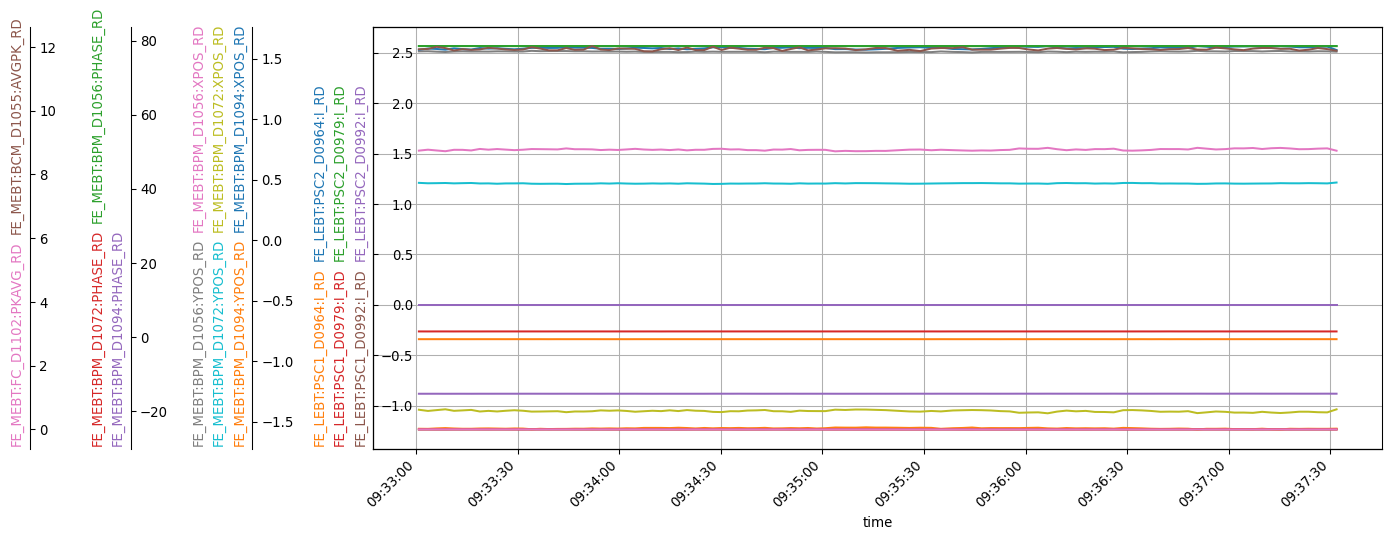

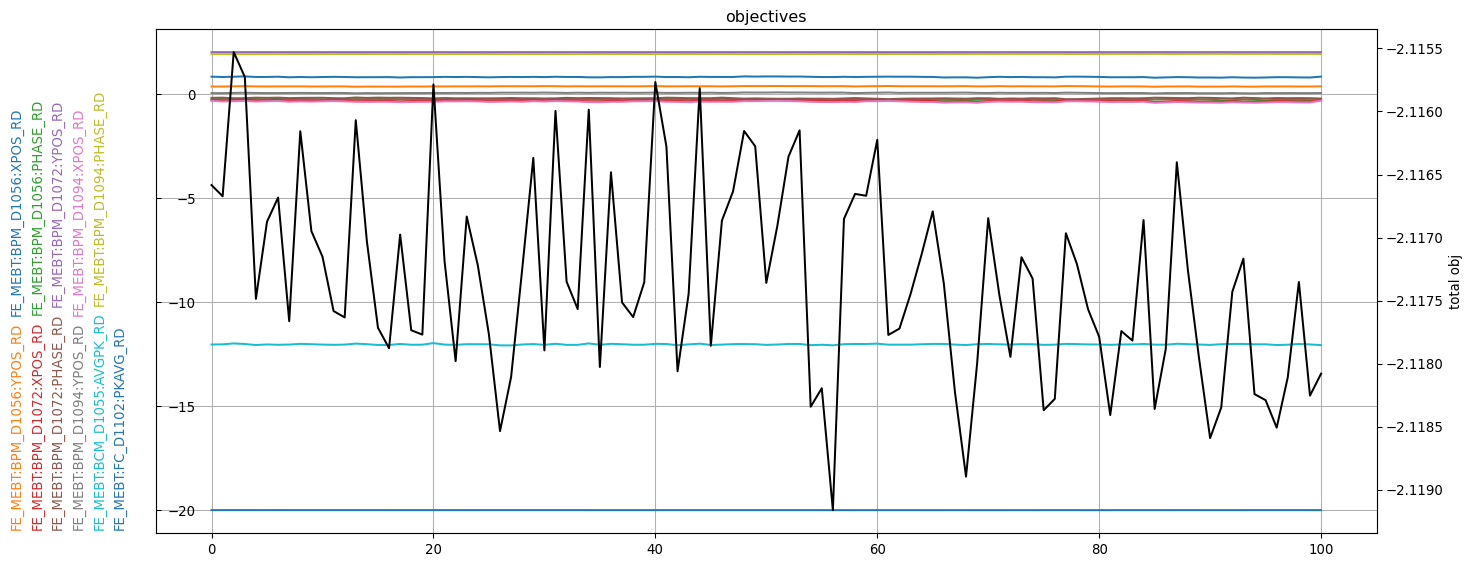

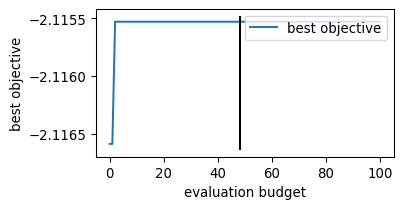

In [19]:
# optimize
ctrBO.init()      # random search
ctrBO.optimize()  # adaptive opt: global -> local -> finetune

### additional optimization

In [ ]:
# ctrBO.optimize_global(niter=4)     # uncomment for additional global search
# ctrBO.optimize_local(niter=4)      # uncomment for additional local search near best solution
# ctrBO.fine_tune(niter=2)           # uncomment for additional finetune near best solution
for f in ctrBO.plot_callbacks:
    f.close()

### plot accumulated best objectives

In [ ]:
fig,ax = plt.subplots(figsize=(4,2),dpi=96)
ctrBO.bo.plot_obj_history(ax=ax, plot_best_only=True)

### set to best solution 

In [20]:
x_best,y_best_old = ctrBO.bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[-1.12603813 -4.2789636   7.10735621 -2.36282282 -1.83955856  0.02680989] -2.1155287326715007 -2.118132010943593


In [23]:
obj.save(fname=os.path.join('/files/shared/ap/jupyter-notebook/data/log/',fname))

# Visualize Surrogate model

starting projection plot...
[████████████████████████████████████████] 100%/100%

starting projection plot...
[████████████████████████████████████████] 100%/100%

starting projection plot...
[████████████████████████████████████████] 100%/100%



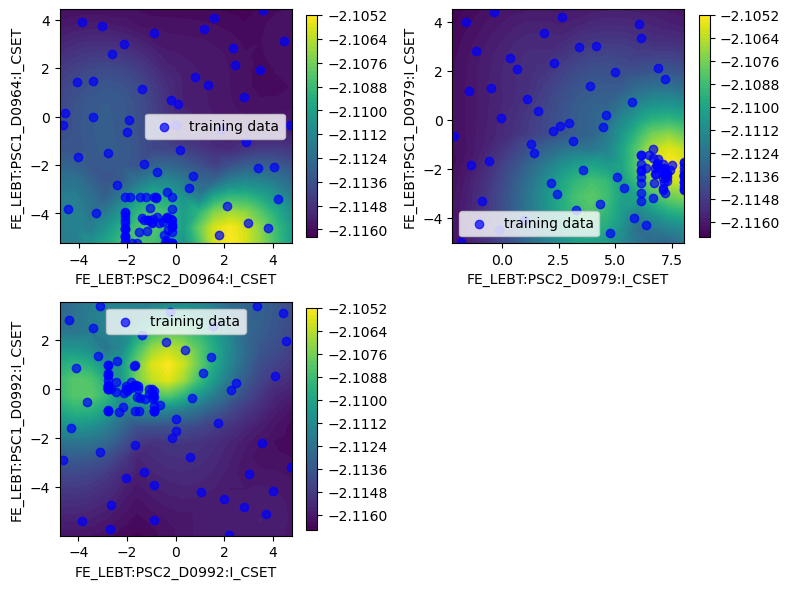

In [22]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4
bo = ctrBO.bo
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fig=fig,ax=ax_);
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()